<a href="https://colab.research.google.com/github/nitin1942003/ML-Hackathon/blob/main/AI_gen_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nitinsharmaiitbbs","key":"db9b62989a47ff09cc6d883baeb757a9"}'}

In [ ]:
import zipfile

# Make a kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json into the kaggle folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3"

In [ ]:
# Train and Test paths
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

# FAKE and REAL image directories
train_fake_dir = os.path.join(train_dir, "FAKE")
train_real_dir = os.path.join(train_dir, "REAL")
test_fake_dir = os.path.join(test_dir, "FAKE")
test_real_dir = os.path.join(test_dir, "REAL")

# List number of images in each category
print("Train FAKE images:", len(os.listdir(train_fake_dir)))
print("Train REAL images:", len(os.listdir(train_real_dir)))
print("Test FAKE images:", len(os.listdir(test_fake_dir)))
print("Test REAL images:", len(os.listdir(test_real_dir)))


Train FAKE images: 50000
Train REAL images: 50000
Test FAKE images: 10000
Test REAL images: 10000


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

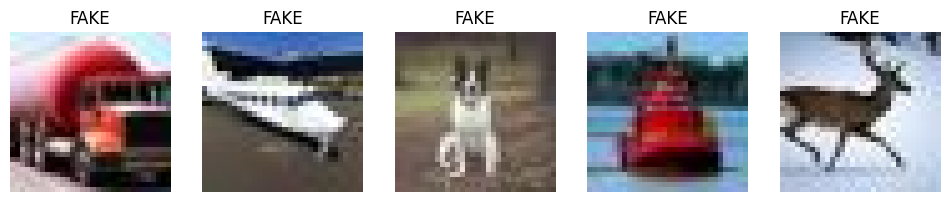

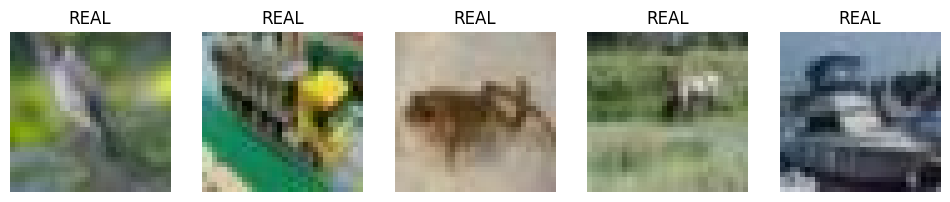

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_sample_images(category_path, category_name):
    images = os.listdir(category_path)
    sample_images = random.sample(images, 5)  # Pick 5 random images

    plt.figure(figsize=(12,6))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(category_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category_name)

    plt.show()

# Show sample FAKE and REAL images from training data
show_sample_images(train_fake_dir, "FAKE")
show_sample_images(train_real_dir, "REAL")

In [ ]:
train_df = pd.DataFrame({'image_path': train_real_dir + train_fake_dir,
                         'label': ['real']*len(train_real_dir) + ['fake']*len(train_fake_dir)})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_df = pd.DataFrame({'image_path': test_real_dir + test_fake_dir,
                        'label': ['real']*len(test_real_dir) + ['fake']*len(test_fake_dir)})

In [ ]:
# Convert labels to binary (real = 1, fake = 0)
train_df['label'] = train_df['label'].map({'real': 1, 'fake': 0})
test_df['label'] = test_df['label'].map({'real': 1, 'fake': 0})

In [ ]:
# Shuffle datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Display first few rows
train_df.head(), test_df.head()

(                                          image_path  label
 0  /root/.cache/kagglehub/datasets/birdy654/cifak...      0
 1  /root/.cache/kagglehub/datasets/birdy654/cifak...      1
 2  /root/.cache/kagglehub/datasets/birdy654/cifak...      1
 3  /root/.cache/kagglehub/datasets/birdy654/cifak...      0
 4  /root/.cache/kagglehub/datasets/birdy654/cifak...      1,
                                           image_path  label
 0  /root/.cache/kagglehub/datasets/birdy654/cifak...      1
 1  /root/.cache/kagglehub/datasets/birdy654/cifak...      0
 2  /root/.cache/kagglehub/datasets/birdy654/cifak...      0
 3  /root/.cache/kagglehub/datasets/birdy654/cifak...      1
 4  /root/.cache/kagglehub/datasets/birdy654/cifak...      1)

In [ ]:
# Define image size and batch size
img_size = (32, 32)
batch_size = 32

In [ ]:
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Includes validation split
test_datagen = ImageDataGenerator(rescale=1./255)  # No validation split for test set

In [ ]:
# Load training images from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to training images
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Uses 80% of images for training
)

Found 80000 images belonging to 2 classes.


In [ ]:
# Load validation images from directory
val_generator = train_datagen.flow_from_directory(
    train_dir,  # Same path as train, but uses split
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Uses 20% of images for validation
)

Found 20000 images belonging to 2 classes.


In [ ]:
# Load test images from directory
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to test images
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Don't shuffle test set
)

Found 20000 images belonging to 2 classes.


In [ ]:
# Print the assigned class labels
print("Class indices:", train_generator.class_indices)

Class indices: {'FAKE': 0, 'REAL': 1}


In [ ]:
# Fetch a batch of images and labels
images, labels = next(train_generator)

# Print the first 10 labels
print("First 10 labels in batch:", labels[:10])

First 10 labels in batch: [1. 0. 0. 0. 1. 0. 0. 1. 0. 1.]


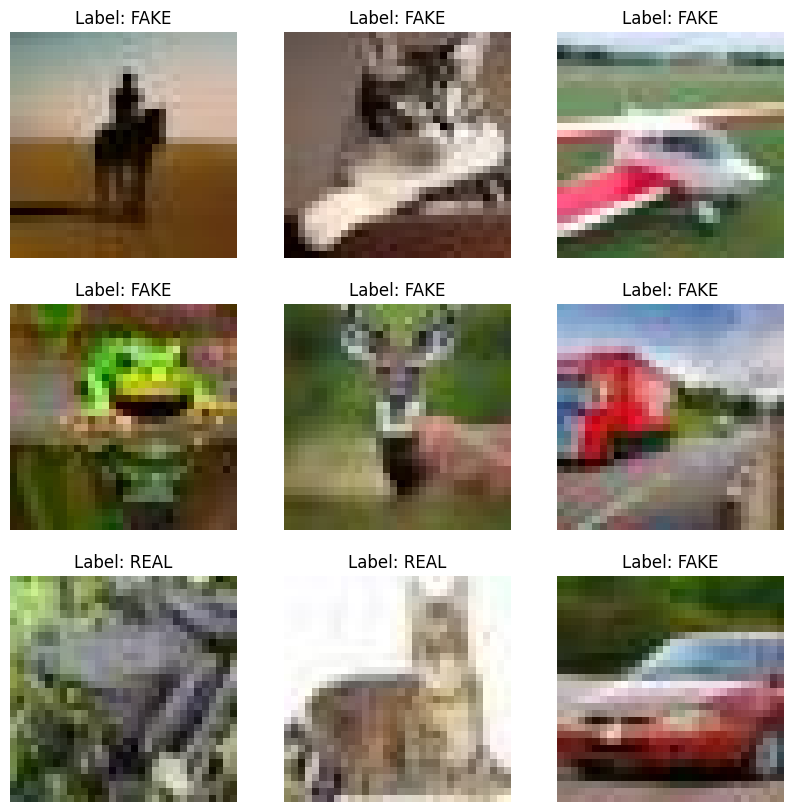

In [ ]:
# Fetch a batch of images and labels
images, labels = next(train_generator)

# Define class names
class_names = {0: 'FAKE', 1: 'REAL'}

# Plot first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Display the image
    plt.title(f"Label: {class_names[int(labels[i])]}")
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import Input

# Mixed precision for speed
set_global_policy('mixed_float16')

# Define the Sequential CNN model
model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid', dtype='float32')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Data generators (assumes already defined)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(32, 32), batch_size=32, class_mode='binary')

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Save best model based on validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=3,
                    callbacks=[checkpoint])


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8456 - loss: 0.3565

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4148s 1s/step - accuracy: 0.8457 - loss: 0.3564 - val_accuracy: 0.8598 - val_loss: 0.3122
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9226 - loss: 0.1957

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4150s 1s/step - accuracy: 0.9226 - loss: 0.1957 - val_accuracy: 0.9324 - val_loss: 0.1728
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4166s 1s/step - accuracy: 0.9317 - loss: 0.1728 - val_accuracy: 0.8289 - val_loss: 0.3752


In [66]:
model.save('model.h5')  # HDF5 format

In [67]:
from tensorflow.keras.models import load_model

# Load your best model
model = load_model('best_model.h5')

In [68]:
# Reset generator and get predictions
val_generator.reset()
y_true = val_generator.classes  # True labels
class_indices = val_generator.class_indices
print("Class Indices:", class_indices)  # Just to confirm 0=Fake, 1=Real

Class Indices: {'FAKE': 0, 'REAL': 1}


In [69]:
# Get predicted probabilities
y_pred_probs = model.predict(val_generator, verbose=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step


In [70]:
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

Confusion Matrix:
[[5214 4786]
 [5029 4971]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.51      0.52      0.52     10000
        Real       0.51      0.50      0.50     10000

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.51      0.51      0.51     20000



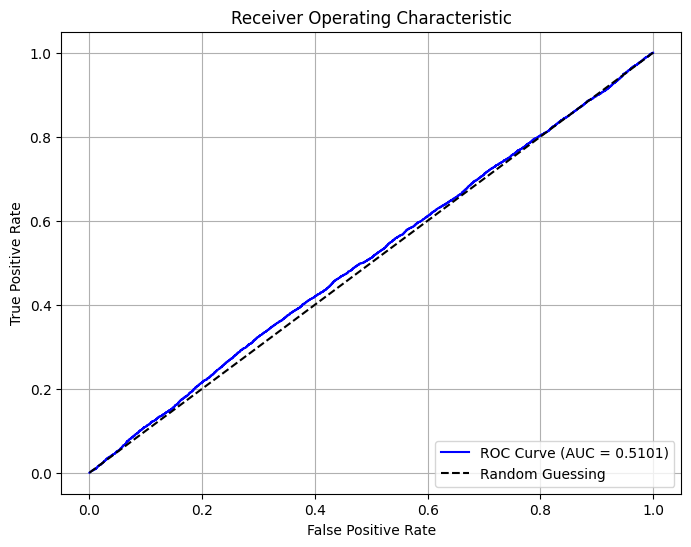

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc), color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()